# Lab 12-1: Transformer Model for Language Understanding
## Exercise: Translator for Portuguese to English
This exercise is taken from TensorFlow Tutorials and modified for TensorFlow 2.x.<br>
https://www.tensorflow.org/text/tutorials/transformer

### Setup Library

In [1]:
!pip install -U 'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

### Load the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [3]:
(ds_train, ds_test, ds_val), ds_info = tfds.load('ted_hrlr_translate/pt_to_en',
                                                 split=['train', 'test', 'validation'],
                                                 as_supervised=True,
                                                 with_info=True)

print(ds_info.features)

Translation({
    'en': Text(shape=(), dtype=tf.string),
    'pt': Text(shape=(), dtype=tf.string),
})


The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

In [4]:
for pt_examples, en_examples in ds_train.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Text tokenization & detokenization

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model).

Download and unzip and import the `saved_model`: <br>
The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [5]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)


'./ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizers = tf.saved_model.load(model_name)

[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [7]:
for en in en_examples.numpy():
    print(en.decode('utf-8'))

encoded = tokenizers.en.tokenize(en_examples)

print()

for row in encoded.to_list():
    print(row)

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [8]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [9]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"

Now take a minute to investigate the distribution of tokens per example in the dataset:

In [10]:
lengths = []

for pt_examples, en_examples in ds_train.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
  
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

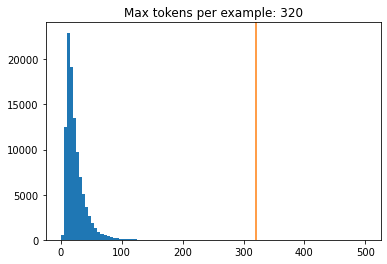

In [11]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

### Setup input pipeline

To build an input pipeline suitable for training define some functions to transform the dataset.

In [12]:
MAX_TOKENS = 128

def filter_max_tokens(pt, en):  # boolean function to show max_length violation
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

def tokenize_pairs(pt, en):  # tokenize (pt, en) pair
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Here's a simple input pipeline that processes, shuffles and batches the data:

In [13]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
    return (ds
           .cache()
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE)
           .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
           .filter(filter_max_tokens)
           .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(ds_train)
val_batches = make_batches(ds_val)

## Implementation of Transformer
### Block Diagram of Transformer
<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="400" alt="transformer">

### Positional encoding

Function `get_angles` return a matrix of radian angles for d_model size. Two consequtive angles are same (one for sin, one for cosine).
$$ pos/n^{2(i//2)/d_{model}} $$
Use this angles to generate positional encoding matrix.

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
  
def positional_encoding(position, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    ### START CODE HERE ###

    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # -> angle_rads has dim (positions,d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = tf.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = tf.cos(angle_rads[:, 1::2])
    
    ### END CODE HERE ###

    pos_encoding = angle_rads[np.newaxis, ...]
  
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


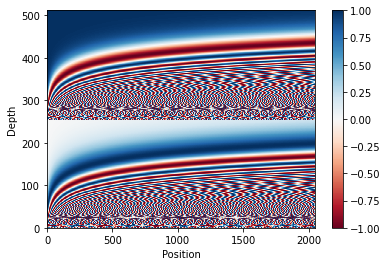

This graph is only to show that each position has unique signiture.


In [15]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

print('This graph is only to show that each position has unique signiture.')

### Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

    Implement the function `scaled_dot_product_attention()` to create attention-based representations
**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. Multiply it by -1e9 before applying the softmax. 

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.

In [16]:
def scaled_dot_product_attention(q, v, k, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    ### START CODE HERE ###
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.sqrt(dk)

    # add the mask to the scaled tensor. Zeros in mask will remove values in softmax layer.
    if mask is not None:
        scaled_attention_logits += (mask-1) * 1e9      # use -1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)                 # (..., seq_len_q, seq_len_k)
    # attention_weights * V
    output = tf.matmul(attention_weights, v)                            # (..., seq_len_q, depth_v)
    
    ### END CODE HERE ###

    return output, attention_weights

In [17]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_v, temp_k, None)
print('Attention weights are:')
print(tf.where(temp_attn<1e-9,0.,temp_attn))
print('Output is:')
print(tf.where(temp_out<1e-9,0.,temp_out))

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


```
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
```

In [18]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_v, temp_k, None)
print('Attention weights are:')
print(tf.where(temp_attn<1e-9,0.,temp_attn))
print('Output is:')
print(tf.where(temp_out<1e-9,0.,temp_out))

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


```
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
```

In [19]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_v, temp_k, None)
print('Attention weights are:')
print(tf.where(temp_attn<1e-9,0.,temp_attn))
print('Output is:')
print(tf.where(temp_out<1e-9,0.,temp_out))

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


```
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
```

In [20]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_v, temp_k, None)
print('Attention weights are:')
print(tf.where(temp_attn<1e-9,0.,temp_attn))
print('Output is:')
print(tf.where(temp_out<1e-9,0.,temp_out))

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


```
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
```

In [21]:
q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)

attention, weights = scaled_dot_product_attention(q, v, k, None)

print('Weights:', weights)
print('weights shape is [q.shape[0], k.shape[1]] =', [q.shape[0], k.shape[1]])
print('Attention:', attention)
print('attension shape is [q.shape[0], v.shape[1]] =', (q.shape[0], v.shape[1]))

mask = np.array([[1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 0, 1]])

attention, weights = scaled_dot_product_attention(q, v, k, mask)
print('Masked MHA results:')
print('Weights:', weights)
print('Attention:', attention)

Weights: tf.Tensor(
[[0.25894776 0.42693266 0.15705977 0.15705977]
 [0.2772748  0.2772748  0.2772748  0.16817565]
 [0.33620113 0.33620113 0.12368149 0.2039163 ]], shape=(3, 4), dtype=float32)
weights shape is [q.shape[0], k.shape[1]] = [3, 4]
Attention: tf.Tensor(
[[0.7410522  0.15705977]
 [0.7227252  0.16817565]
 [0.6637989  0.2039163 ]], shape=(3, 2), dtype=float32)
attension shape is [q.shape[0], v.shape[1]] = (3, 2)
Masked MHA results:
Weights: tf.Tensor(
[[0.30719587 0.5064804  0.         0.18632373]
 [0.38365173 0.38365173 0.         0.23269653]
 [0.38365173 0.38365173 0.         0.23269653]], shape=(3, 4), dtype=float32)
Attention: tf.Tensor(
[[0.6928041  0.18632373]
 [0.61634827 0.23269653]
 [0.61634827 0.23269653]], shape=(3, 2), dtype=float32)


**Expected Outputs**
```
Weights: tf.Tensor(
[[0.25894776 0.42693266 0.15705977 0.15705977]
 [0.2772748  0.2772748  0.2772748  0.16817565]
 [0.33620113 0.33620113 0.12368149 0.2039163 ]], shape=(3, 4), dtype=float32)
weights shape is [q.shape[0], k.shape[1]] = [3, 4]
Attention: tf.Tensor(
[[0.74121094 0.15710449]
 [0.7229004  0.16821289]
 [0.6636963  0.20385742]], shape=(3, 2), dtype=float32)
attension shape is [q.shape[0], v.shape[1]] = (3, 2)
Masked MHA results:
Weights: tf.Tensor(
[[0.30719587 0.5064804  0.         0.18632373]
 [0.38365173 0.38365173 0.         0.23269653]
 [0.38365173 0.38365173 0.         0.23269653]], shape=(3, 4), dtype=float32)
Attention: tf.Tensor(
[[0.69262695 0.1862793 ]
 [0.61621094 0.23266602]
 [0.61621094 0.23266602]], shape=(3, 2), dtype=float32)
```

### Multi-head attention

A `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [22]:
USE_TF_MHA = True    # use TensorFlow's MHA

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, num_heads, key_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.depth = key_dim
        self.d_model = num_heads * key_dim

        self.wq = tf.keras.layers.Dense(self.d_model)
        self.wv = tf.keras.layers.Dense(self.d_model)
        self.wk = tf.keras.layers.Dense(self.d_model)
        self.wo = tf.keras.layers.Dense(self.d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x

    def call(self, query, value, key, attention_mask, return_attention_scores=False):
        batch_size = tf.shape(query)[0]
        seq_length = tf.shape(query)[1]
     
        ### START CODE HERE ###
        
        # In fully implemented MHA, linear transform generates num_heads qkv.
        # However in this implementation, qvk are generated by linear transform,
        # and just splited into num_heads qkv's.
        q = self.wq(query)         # linear of query
        k = self.wk(key)         # linear of key
        v = self.wv(value)         # linear of value

        # split heads; depth = d_model / num_heads
        q = self.split_heads(q, batch_size)         # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)         # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)         # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, v, k, attention_mask)

        # transpose scaled_attention dimension to reshape for concatenation
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # reshape for concatenation
        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_length, self.d_model))

        output = self.wo(concat_attention)    # linear for output

        ### END CODE HERE ###

        if return_attention_scores:
            return output, attention_weights
        else:
            return output

In [23]:
tf.random.set_seed(1)

depth = 512 // 8

temp_mha = MultiHeadAttention(num_heads=8, key_dim=depth)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

out, attn = temp_mha(query=y, value=y, key=y, attention_mask=None, return_attention_scores=True)

print(out.shape, attn.shape)
print('output:\n', out[0,1,2:5])
print('attention:\n', attn[0,1,2,3:5])

(1, 60, 512) (1, 8, 60, 60)
output:
 tf.Tensor([-0.40905493 -0.41578254 -0.6810747 ], shape=(3,), dtype=float32)
attention:
 tf.Tensor([0.01670659 0.01086566], shape=(2,), dtype=float32)


**Expected Output**
```
(1, 60, 512) (1, 8, 60, 60)
output:
 tf.Tensor([ 0.40168968 -0.00975254  0.14952728], shape=(3,), dtype=float32)
attention:
 tf.Tensor([0.02182075 0.01658176], shape=(2,), dtype=float32)
```

### Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [24]:
def feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [25]:
tf.random.set_seed(1)

sample_ffn = feed_forward_network(512, 2048)
sample_ffn_output = sample_ffn(tf.random.uniform((64, 50, 512)), False)

print(sample_ffn_output.shape)
print(sample_ffn_output[1,2,3:5])

(64, 50, 512)
tf.Tensor([ 0.30389914 -0.27193618], shape=(2,), dtype=float32)


**Expected Output**
```
(64, 50, 512)
tf.Tensor([ 0.3038992  -0.27193666], shape=(2,), dtype=float32)
```

### Encoder and decoder

A transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask)
2.   Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in a transformer.

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
    
        depth = d_model // num_heads

        if USE_TF_MHA:
            self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, 
                                                          key_dim=depth, 
                                                          attention_axes=1)
        else:
            self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=depth)
        self.ffn = feed_forward_network(d_model, dff)
    
        self.lyrnorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.lyrnorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        ### START CODE HERE ###
    
        attn_out = self.mha(query=x, value=x, key=x, attention_mask=mask)
        drpout1 = self.dropout1(attn_out, training=training)
        out1 = self.lyrnorm1(x + drpout1)               # add and norm
    
        ffn_out = self.ffn(out1)
        drpout2 = self.dropout2(ffn_out, training=training)
        out2 = self.lyrnorm2(out1 + drpout2)               # add and norm
    
        ### END CODE HERE ###
    
        return out2

In [27]:
tf.random.set_seed(1)

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)
print(sample_encoder_layer_output[1,2,3:5])

(64, 43, 512)
tf.Tensor([-0.37004527  1.0009404 ], shape=(2,), dtype=float32)


**Expected Output**
```
(64, 43, 512)
tf.Tensor([-0.37822643  0.934906  ], shape=(2,), dtype=float32)
```

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are a number of decoder layers in the model.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
    
        depth = d_model // num_heads

        if USE_TF_MHA:
            self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, 
                                                           key_dim=depth, 
                                                           attention_axes=1)
            self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, 
                                                           key_dim=depth, 
                                                           attention_axes=1)

        else:
            self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=depth)
            self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=depth)

        self.ffn = feed_forward_network(d_model, dff)
    
        self.lyrnorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.lyrnorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.lyrnorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        ### START CODE HERE ###
    
        attn1, attn_weights_blk1 = self.mha1(query=x, value=x, key=x, attention_mask=look_ahead_mask, return_attention_scores=True)       # decoder needs return_attention_scores
        drpout1 = self.dropout1(attn1, training=training)
        out1 = self.lyrnorm1(x + drpout1)               # add and norm
    
        attn2, attn_weights_blk2 = self.mha2(query=out1, value=enc_output, key=enc_output, attention_mask=padding_mask, return_attention_scores=True)       # decoder needs return_attention_scores
        drpout2 = self.dropout2(attn2, training=training)
        out2 = self.lyrnorm2(out1 + drpout2)               # add and norm
    
        ffn_out = self.ffn(out2)
        drpout3 = self.dropout3(ffn_out, training=training)
        out3 = self.lyrnorm3(out2 + drpout3)               # add and norm
    
        ### END CODE HERE ###
    
        return out3, attn_weights_blk1, attn_weights_blk2 # return weights for demonstration purpose later

In [29]:
tf.random.set_seed(1)

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)
print(sample_decoder_layer_output[1,2,3:5])

(64, 50, 512)
tf.Tensor([-0.77358216  0.73916036], shape=(2,), dtype=float32)


**Expected Output**
```
(64, 50, 512)
tf.Tensor([-0.71290076  0.8702707 ], shape=(2,), dtype=float32)
```

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
                 rate=0.1):
        super(Encoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]
    
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

      seq_len = tf.shape(x)[1]
  
      ### START CODE HERE ###
  
      # adding embedding and position encoding.
      x = self.embedding(x)                     # embedding
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # embedding is multiplied by sqrt(d_model) for sharing
      x += self.pos_encoding[:,:seq_len, :]                    # positional encoding
  
      x = self.dropout(x, training=training)                     # dropout
  
      for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)
  
      ### END CODE HERE ###
  
      return x  # (batch_size, input_seq_len, d_model)

In [31]:
tf.random.set_seed(1)

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)
print(sample_encoder_output[1,2,3:5])

(64, 62, 512)
tf.Tensor([-0.10983554 -0.55921453], shape=(2,), dtype=float32)


**Expected Output**
```
(64, 62, 512)
tf.Tensor([-0.10563795 -0.48032904], shape=(2,), dtype=float32)
```

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [32]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
                 rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)
    
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        ### START CODE HERE ###
    
        x = self.embedding(x)                     # embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # embedding is multiplied by sqrt(d_model) for sharing
        x += self.pos_encoding[:,:seq_len]                    # positional encoding
    
        x = self.dropout(x, training=training)                     # dropout
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
      
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
    
        ### END CODE HERE ###
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [33]:
tf.random.set_seed(1)

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

print(output.shape, attn['decoder_layer2_block2'].shape)
print('output:\n', output[1,2,3:5])
print('attention:\n', attn['decoder_layer2_block2'][1,:,3,4])

(64, 26, 512) (64, 8, 26, 62)
output:
 tf.Tensor([-0.82724607  1.1501614 ], shape=(2,), dtype=float32)
attention:
 tf.Tensor(
[0.01651793 0.0163075  0.0162483  0.01605796 0.01601784 0.01617665
 0.01561136 0.01609982], shape=(8,), dtype=float32)


**Expected Output**
```
(64, 26, 512) (64, 8, 26, 62)
output:
 tf.Tensor([-0.82862216  1.094392  ], shape=(2,), dtype=float32)
attention:
 tf.Tensor(
[0.01620403 0.01613934 0.01616153 0.01623142 0.01612685 0.01616484
 0.01608258 0.01610816], shape=(8,), dtype=float32)
```

### Create the transformer model

A transformer consists of the encoder, decoder, and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. SInce the sequence has zero pads after end of sentence, create a mask to exclude non-sentence area.<br>
The mask have 1s for elements to use.

In [34]:
def create_padding_mask(seq):
    ### START CODE HERE ###

    padding_mask = tf.where(seq != 0, 1, 0)      # true if not zero; seq has (b,s) dimension
    padding_mask = tf.expand_dims(tf.expand_dims(padding_mask, axis=1), axis=1)      # add two extra dimensions to add the padding to the attention logits.
    padding_mask = tf.cast(padding_mask, tf.float32)      # type cast to float32

    ### END CODE HERE ###

    return padding_mask

In [35]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
temp = create_padding_mask(x)
print(temp)

tf.Tensor(
[[[[1. 1. 0. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]


 [[[0. 0. 0. 1. 1.]]]], shape=(3, 1, 1, 5), dtype=float32)


**Expected Output**
```
tf.Tensor(
[[[[1. 1. 0. 0. 1.]]]
 [[[1. 1. 1. 0. 0.]]]
 [[[0. 0. 0. 1. 1.]]]], shape=(3, 1, 1, 5), dtype=float32)
```

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.<br>
This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.<br>
The mask have 1s for elements to use.

In [36]:
def create_look_ahead_mask(seq):
    ### START CODE HERE ###

    padding_mask = tf.ones_like(seq)      # true if not zero; seq has (b,s) dimension
    t_size = seq.shape[-1]            # find max length of the decoder input
    if t_size is None: return None
    causality_mask = tf.linalg.band_part(tf.ones([t_size, t_size]), -1, 0)    # create lower triangular mat; use band_part
    look_ahead_mask = tf.reshape(causality_mask, [1, 1, t_size, t_size])   # make lower trinagular padding; be carefule with padding_mask dimension
    look_ahead_mask = tf.cast(look_ahead_mask, tf.float32)   # type cast to float32

    ### END CODE HERE ###
    
    return look_ahead_mask

In [37]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x)
print(temp)

tf.Tensor(
[[[[1. 0. 0.]
   [1. 1. 0.]
   [1. 1. 1.]]]], shape=(1, 1, 3, 3), dtype=float32)


**Expected Output**
```
tf.Tensor(
[[[[1. 0. 0.]
   [1. 1. 0.]
   [1. 1. 1.]]]], shape=(1, 1, 3, 3), dtype=float32)
```

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               input_vocab_size=input_vocab_size, rate=rate)
    
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               target_vocab_size=target_vocab_size, rate=rate)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs
    
        ### START CODE HERE ###
        enc_padding_mask = dec_padding_mask = create_padding_mask(inp)
        look_ahead_mask = create_look_ahead_mask(tar)
    
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        ### END CODE HERE ###
    
        return final_output, attention_weights

In [39]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)
print(fn_out[1,2,3:5])

(64, 36, 8000)
tf.Tensor([ 0.51292217 -0.29853508], shape=(2,), dtype=float32)


**Expected Output**
```
(64, 36, 8000)
tf.Tensor([ 0.45717314 -0.2944983 ], shape=(2,), dtype=float32)
```

## Set hyperparameters

To keep this example small and relatively fast, the values for `num_layers, d_model, dff` have been reduced. 

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [40]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

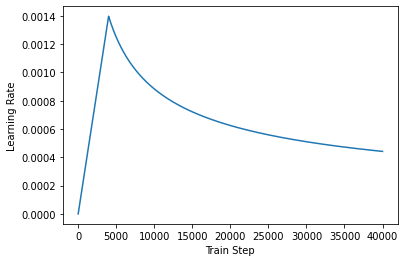

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
  
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
  
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [47]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence = 'SOS A lion in the jungle is sleeping EOS'` becomes:

* `tar_inp =  'SOS A lion in the jungle is sleeping'`
* `tar_real = 'A lion in the jungle is sleeping EOS'`

A transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the model predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [48]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:  ]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                     training = True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [49]:
import time
import tqdm

steps = min(len(list(train_batches)), 696) # the result may vary btw 696 to 706

print(steps)

696


In [50]:
epochs = 10

In [51]:
for epoch in range(epochs):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    pbar = tqdm.notebook.tqdm(train_batches, total=steps)
    pbar.set_description('Epoch:%2d' % (epoch+1))

    # inp -> portuguese, tar -> english
    for batch in pbar:
        inp, tar = batch
        train_step(inp, tar)
        #train_step(batch)

        pbar.set_postfix({'loss' : train_loss.result().numpy(), 'acc' : train_accuracy.result().numpy()})

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 1 Loss 6.8274 Accuracy 0.1172
Time taken for 1 epoch: 88.63 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 2 Loss 4.2935 Accuracy 0.3609
Time taken for 1 epoch: 82.49 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 3 Loss 2.0943 Accuracy 0.6744
Time taken for 1 epoch: 82.50 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 4 Loss 0.7843 Accuracy 0.8766
Time taken for 1 epoch: 78.21 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 5 Loss 0.3314 Accuracy 0.9458
Time taken for 1 epoch: 77.45 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 6 Loss 0.1941 Accuracy 0.9662
Time taken for 1 epoch: 78.19 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 7 Loss 0.1227 Accuracy 0.9785
Time taken for 1 epoch: 77.46 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 8 Loss 0.0824 Accuracy 0.9858
Time taken for 1 epoch: 78.07 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 9 Loss 0.0601 Accuracy 0.9897
Time taken for 1 epoch: 77.64 secs



  0%|          | 0/696 [00:00<?, ?it/s]

Epoch 10 Loss 0.0478 Accuracy 0.9920
Time taken for 1 epoch: 78.55 secs



### Run inference

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [52]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer
  
    def __call__(self, sentence, max_length=MAX_TOKENS):
        # input sentence is portuguese, hence adding the start and end token
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
    
        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    
        encoder_input = sentence
    
        # As the output language is english, initialize the output with the
        # english start token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]
    
        # `tf.TensorArray` is required here (instead of a python list) so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
    
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)
      
            # select the last token from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
      
            predicted_id = tf.argmax(predictions, axis=-1)
      
            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.
            output_array = output_array.write(i+1, predicted_id[0])
      
            if predicted_id == end:
                break
    
        output = tf.transpose(output_array.stack())
        # output.shape (1, tokens)
        text = tokenizers.en.detokenize(output)[0]  # shape: ()
    
        tokens = tokenizers.en.lookup(output)[0]
    
        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop. So recalculate them outside
        # the loop.
        _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)
    
        return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to [NMT with attention](nmt_with_attention.ipynb) for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [53]:
translator = Translator(tokenizers, transformer)

In [54]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [55]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart
Ground truth   : this is a problem we have to solve .


In [56]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart
Ground truth   : and my neighboring homes heard about this idea .


In [57]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart
Ground truth   : so i'll just share with you some stories very quickly of some magical thi

## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [58]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart
Ground truth   : this is the first book i've ever done.


In [59]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]
  
    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
  
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)
  
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [60]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
    attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([128, 11])

In [61]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [62]:
translated_tokens

<tf.Tensor: shape=(129,), dtype=string, numpy=
array([b'[START]', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apart', b'apart', b'apart', b'apart', b'apart', b'apart',
       b'apar

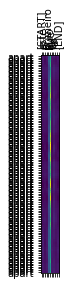

In [63]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [64]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    in_tokens
  
    fig = plt.figure(figsize=(16, 8))
  
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
    
        plot_attention_head(in_tokens, translated_tokens, head)
    
        ax.set_xlabel(f'Head {h+1}')
  
    plt.tight_layout()
    plt.show()

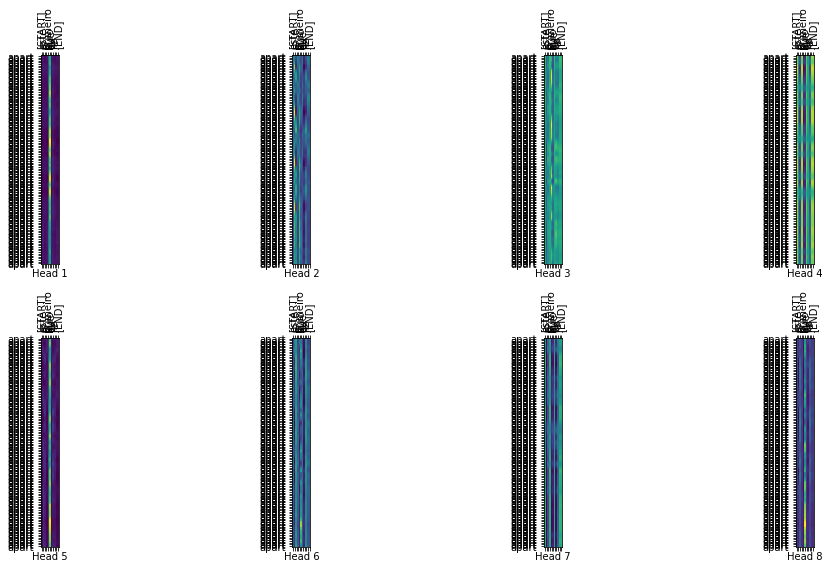

In [65]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart
Ground truth   : I read about triceratops in the encyclopedia.


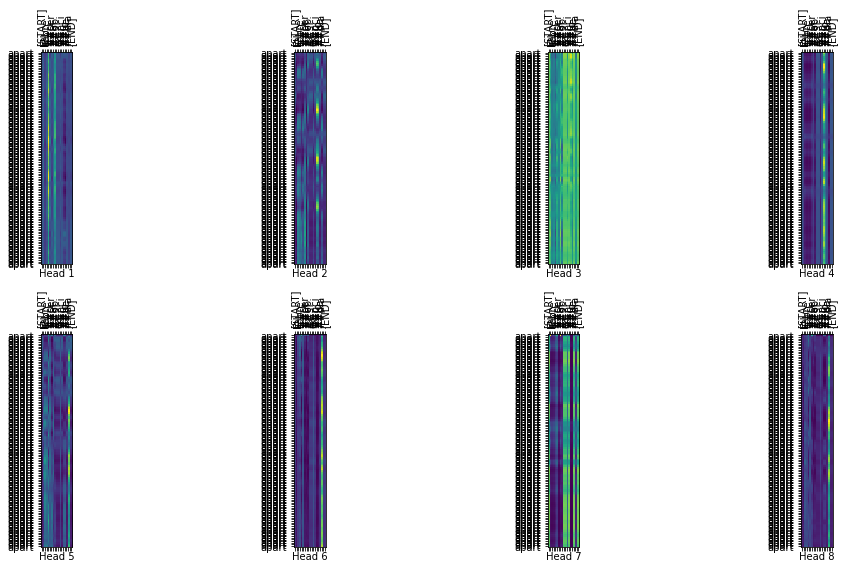

In [66]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [67]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
         tokens,
         attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)
    
        return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [68]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [69]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart'

In [70]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [71]:
reloaded = tf.saved_model.load('translator')

In [72]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart apart'

## Summary

In this tutorial you learned about:

* positional encoding
* multi-head attention
* the importance of masking 
* and how to put it all together to build a transformer.

This implementation tried to stay close to the implementation of the 
[original paper](https://arxiv.org/abs/1706.03762). If you want to practice there are many things you could try with it. For example: 

* Using a different dataset to train the transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805).
* Implement beam search to get better predictions.